# Problem Set 1

## Question 4

Continuing with the model (4), we numerically investigate the performance of various estimators designed for static panel data models, namely, $\hat\beta_{n,\mathrm{POLS}}$, $\hat\beta_{n,\mathrm{FE}}$, $\hat\beta_{n,\mathrm{FD}}$, and the first differenced estimator using $Y_{i,t-2}$ as instrument (i.e., the IV estimator of $\beta_0$ for the first-differenced equation using $Y_{i,t-2}$ as instrument). First, for each triple $(n,T,\beta_0)$ to be specified shortly, obtain the sample as follows.

1. Simulate $\alpha_i\overset{\mathrm{iid}}{\sim} N(0,1)$ and $\epsilon_i\overset{\mathrm{iid}}{\sim} N(0,1)$.

2. Generate $Y_{i0}$ according to $Y_{i0}=0.5\alpha_i + \epsilon_i$.

3. Generate $Y_{it}$ according to (4) with $V_{it}\overset{\mathrm{iid}}{\sim} N(0,1)$.

You may then compute the aforementioned estimators with the generated sample. Repeat the above steps $1000$ times, let $\hat\beta^{(r)}$ be the estimate based on the $i$th replication (for a particular estimator), and then the finite sample bias, standard error and root mean squared error are computed as follows:

\begin{align}
    \mathrm{Bias}(\hat\beta)&=\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)} - \beta_0~,\\
    \mathrm{SE}(\hat\beta)&=\{\frac{1}{1000}\sum_{r=1}^{1000}(\hat\beta^{(r)}-\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)})^2 \}^{1/2}~,\\
    \mathrm{RMSE} (\hat\beta) & = \{[\mathrm{Bias}(\hat\beta)]^2 + [\mathrm{SE}(\hat\beta)]^2\}^{1/2}~.
\end{align}

1. Let $n=100$ and $T=6$. Graph the bias, se and rmse of each estimator as functions of $\beta_0\in\{0,0.25,0.5,0.75,1\}$.

In [1]:
import os
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import linearmodels.panel as lm

def DGP(n,T,b0 = 0.5):
    a = np.random.normal(0,1,n)
    e = np.random.normal(0,1,n)
    
    Y0 = 0.5*a + e  # n by 1
    Ymatrix = np.zeros([n, T])  # n by T then stack
    Xmatrix = np.zeros([n, T])
    for t in range(T):
        V = np.random.normal(0,1,n)
        if t == 0:
            Y1 = b0*Y0 + a + V
            Ymatrix[:,t] = Y1
            Xmatrix[:,t] = Y0
        else:
            Y0 = Ymatrix[:,t-1]
            Y1 = b0*Y0 + a + V
            Ymatrix[:,t] = Y1
            Xmatrix[:,t] = Y0
    
    Y = Ymatrix.reshape(-1)
    X = Xmatrix.reshape(-1)
    i = np.kron(np.array([i+1 for i in range(n)]).reshape(n,1), np.ones(T).reshape(T,1)).reshape(-1)
    t = np.kron(np.ones(n).reshape(n,1), np.array([i+1 for i in range(T)]).reshape(T,1)).reshape(-1)
    df = pd.DataFrame({'i':i,'t':t,'Y':Y,'X':X})
    
    return df

def test_DGP(n,T,b0 = 0.5):
    """
    X is exogenous
    """
    a = np.random.normal(0,1,n)
    e = np.random.normal(0,1,n)
    
    Y0 = 0.5*a + e  # n by 1
    Ymatrix = np.zeros([n, T])  # n by T -> stack using reshape.
    Xmatrix = np.zeros([n, T])
    for t in range(T):
        V = np.random.normal(0,1,n)
        X = np.random.normal(0,1,n)
        Y = b0 * X + a + V        
        Ymatrix[:,t] = Y
        Xmatrix[:,t] = X
    Y = Ymatrix.reshape(-1)
    X = Xmatrix.reshape(-1)
    i = np.kron(np.array([i+1 for i in range(n)]).reshape(n,1), np.ones(T).reshape(T,1)).reshape(-1)
    t = np.kron(np.ones(n).reshape(n,1), np.array([i+1 for i in range(T)]).reshape(T,1)).reshape(-1)
    df = pd.DataFrame({'i':i,'t':t,'Y':Y,'X':X})
    
    return df

def my_OLS(Y,X):
    beta = np.linalg.solve(X.T@X, X.T@Y)
    
    return beta[0]

def my_FE(Y,X,T):
    nT, k = X.shape
    n = int(nT/T)
    Qi = np.eye(T) - (np.ones(T).reshape(T,1) @ np.ones(T).reshape(1,T))/T
    Q = np.kron(np.eye(n), Qi)
    
    beta = np.linalg.solve(X.T @ Q @ X , X.T @ Q @ Y)
    
    return beta[0]

def my_FD(Y,X,T):
    nT,k = X.shape
    n = int(nT/T)
    
    toep = toeplitz([-1,*np.zeros(T-2)],[0,1,*np.zeros(T-2)])
    dY = np.kron(np.eye(n),toep) @ Y
    dX = np.kron(np.eye(n),toep) @ X
    
    beta = my_OLS(dY,dX)
    return beta[0]

def my_FD_IV(Y,X,T, method="2SLS"):
    nT,k = X.shape
    n = int(nT/T)
    
    toep = toeplitz([-1,*np.zeros(T-2)],[0,1,*np.zeros(T-2)])[1:,:]
    dY = np.kron(np.eye(n),toep) @ Y
    dX = np.kron(np.eye(n),toep) @ X
    
    sel = np.eye(T)[:-2,:]
    Z = np.kron(np.eye(n),sel) @ Y
    
#     Y_nbyT = Y.reshape(n, T)  # [Y_{t=1}, Y_{t=2}, ..., Y_{t=T}]
#     X_nbyT = X.reshape(n, T)
#     Y_nbyT_lag = np.column_stack([np.zeros(n), Y_nbyT[:,:-1]])  # [0,t=2-1,t=3-2,...]
#     X_nbyT_lag = np.column_stack([np.zeros(n), X_nbyT[:,:-1]])
    
#     dY = (Y_nbyT-Y_nbyT_lag)[:,2:].reshape([n*(T-2),1])  # vec[Y_{t=3-2}, Y_{t=4-3}, ...]
#     dX = (X_nbyT-X_nbyT_lag)[:,2:].reshape([n*(T-2),k])  # vec[Y_{t=2-1}, Y_{t=3-2}, ...]
#     iv = Y_nbyT[:,:-2].reshape([n*(T-2),1])  # vec[Y_{t=1}, Y_{t=2}, ..., Y_{t=T-2}]
    
    # 2SLS
    if method == "2SLS":
        dXhat = Z @ (np.linalg.inv(Z.T@Z) @ (Z.T@dX))
        beta = my_OLS(dY,dXhat)
    if method == "IV":
        nom = dX.T@Z @ np.linalg.inv(Z.T@Z) @ Z.T@dY
        denom = dX.T@Z @ np.linalg.inv(Z.T@Z) @ Z.T@dX
        beta = np.linalg.inv(denom) @ nom
        beta = beta[0]
    if method == "IV_just":
        beta = np.linalg.inv(Z.T@dX) @ Z.T@dY

    return beta

def simulation_Q3(n,T,M=1000,test=False):
    res = []
    for b0 in [0, 0.25, 0.5, 0.75, 1]:
        res_POLS = np.zeros(M)
        res_FE = np.zeros(M)
        res_FD = np.zeros(M)
        res_FD_IV = np.zeros(M)
    
        for m in range(M):
            if test is True:
                df = test_DGP(n=n,T=T,b0=b0)
                Y = np.array(df.Y).reshape(n*T,1)
                X = np.array(df.X).reshape(n*T,1)
            else:
                df = DGP(n=n,T=T,b0=b0)
                Y = np.array(df.Y).reshape(n*T,1)
                X = np.array(df.X).reshape(n*T,1)
            res_POLS[m] = my_OLS(Y,X)
            res_FE[m] = my_FE(Y,X,T=T)
            res_FD[m] = my_FD(Y,X,T=T)
            res_FD_IV[m] = my_FD_IV(Y,X,T=T,method="2SLS")
    
        res.append({"POLS":res_POLS, "FE":res_FE,"FD":res_FD,"FD_IV":res_FD_IV})
    return res

def figure_Q3(res, n, T, save=False):
    b0 = np.array([0,0.25,0.5,0.75,1.])
    result_000 = res[0]
    
    result_000_POLS = result_000["POLS"]
    
    result_025 = res[1]
    result_050 = res[2]
    result_075 = res[3]
    result_100 = res[4]
          
    bias_POLS = [res[i]["POLS"].mean() - b0[i] for i in range(len(res))]
    bias_FE = [res[i]["FE"].mean() - b0[i] for i in range(len(res))]
    bias_FD = [res[i]["FD"].mean() - b0[i] for i in range(len(res))]
    bias_FD_IV = [res[i]["FD_IV"].mean() - b0[i] for i in range(len(res))]

    std_POLS = [res[i]["POLS"].std() for i in range(len(res))]
    std_FE = [res[i]["FE"].std() for i in range(len(res))]
    std_FD = [res[i]["FD"].std() for i in range(len(res))]
    std_FD_IV = [res[i]["FD_IV"].std() for i in range(len(res))]
    
    rmse_POLS = [np.sqrt(bias_POLS[i]**2 + std_POLS[i]**2) for i in range(len(res))]
    rmse_FE = [np.sqrt(bias_FE[i]**2 + std_FE[i]**2) for i in range(len(res))]
    rmse_FD = [np.sqrt(bias_FD[i]**2 + std_FD[i]**2) for i in range(len(res))]
    rmse_FD_IV = [np.sqrt(bias_FD_IV[i]**2 + std_FD_IV[i]**2) for i in range(len(res))]
    
    fig, ax = plt.subplots(1,3,figsize = (21,4))
    
    ax[0].plot(b0, bias_POLS)
    ax[0].plot(b0, bias_FE)
    ax[0].plot(b0, bias_FD)
    ax[0].plot(b0, bias_FD_IV)
    ax[0].axhline(0, color='black')
    ax[0].legend(["POLS", "FE", "FD", "FD_IV"])
    ax[0].set_xlabel('b0')
    ax[0].set_title("Bias of simulation (n={},T={})".format(n,T))

    ax[1].plot(b0, std_POLS)
    ax[1].plot(b0, std_FE)
    ax[1].plot(b0, std_FD)
    ax[1].plot(b0, std_FD_IV)
    ax[1].legend(["POLS", "FE", "FD", "FD_IV"])
    ax[1].set_xlabel('b0')
    ax[1].set_title("SE of simulation (n={},T={})".format(n,T))

    ax[2].plot(b0, rmse_POLS)
    ax[2].plot(b0, rmse_FE)
    ax[2].plot(b0, rmse_FD)
    ax[2].plot(b0, rmse_FD_IV)
    ax[2].legend(["POLS", "FE", "FD", "FD_IV"])
    ax[2].set_xlabel('b0')
    ax[2].set_title("RMSE of simulation (n={},T={})".format(n,T))
    
    fig.savefig('fig_n{}_T{}.jpg'.format(n,T), dpi=80)

    return fig

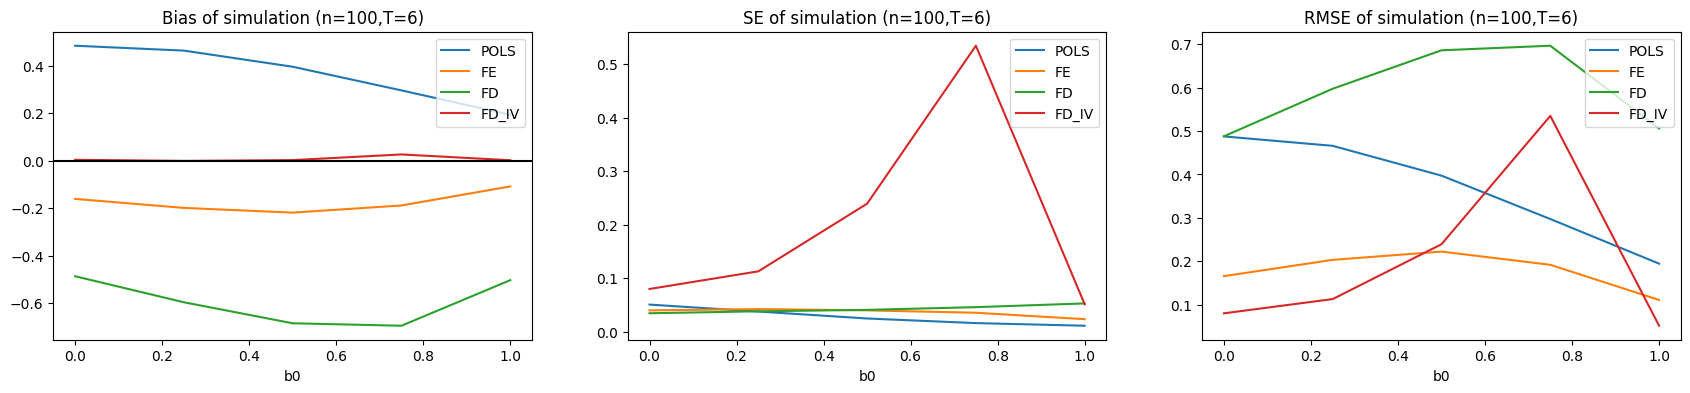

In [2]:
results_n100_T6 = simulation_Q3(n=100,T=6,M=1000)
fig_n100_T6 = figure_Q3(results_n100_T6, n=100,T=6, save=True)

2 . Repeat part (1) with $(n,T)=(100,3)$ and $(n,T)=(100,9)$.

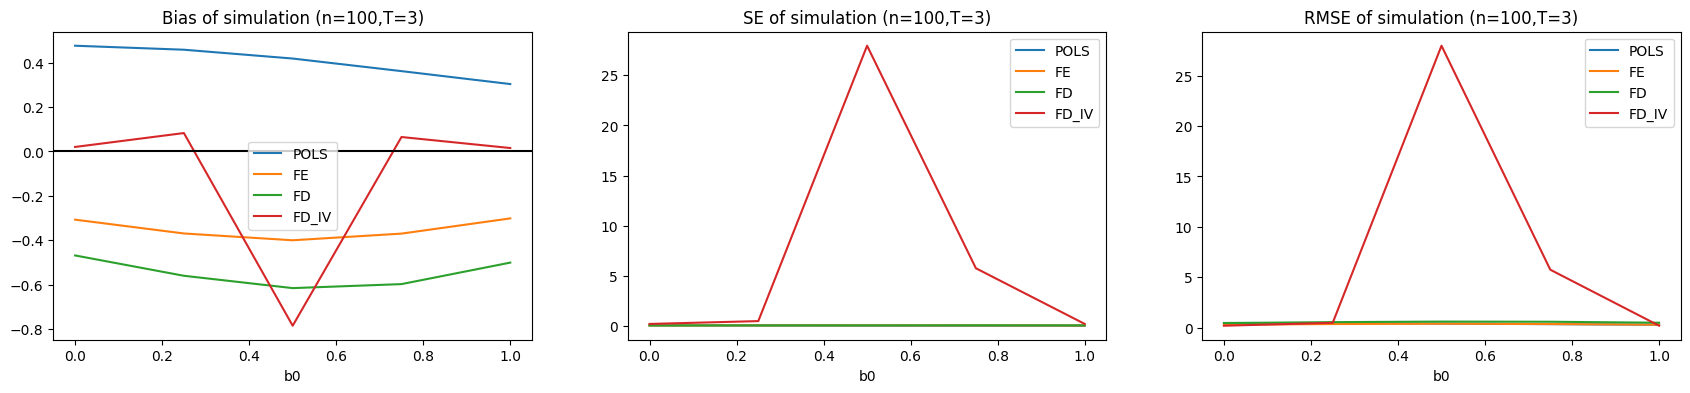

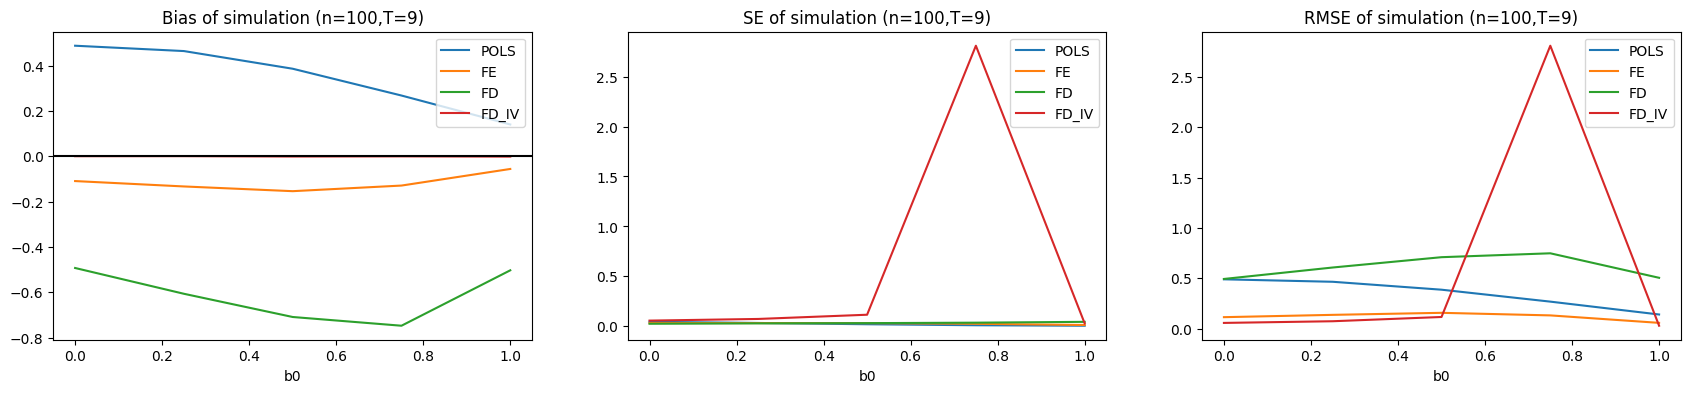

In [3]:
n,T = 100,3
results_n100_T3 = simulation_Q3(n=n,T=T,M=1000)
fig_n100_T3 = figure_Q3(results_n100_T3, n=n,T=T, save=True)

n,T = 100,9
results_n100_T9 = simulation_Q3(n=n,T=T,M=1000)
fig_n100_T9 = figure_Q3(results_n100_T9, n=n,T=T, save=True)

In [4]:
from pydynpd import regression
_data = test_DGP(n=100,T=6,b0=0.5)
command_str='Y L1.Y  | gmm(Y, 2:.) | nolevel'
mydpd = regression.abond(command_str, _data, ['i', 't'])

mydpd.models[0].regression_table.coefficient[0]

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: i                                Number of obs = 400     
 Time variable: t                                 Min obs per group: 4    
 Number of instruments = 10                       Max obs per group: 4    
 Number of groups = 100                           Avg obs per group: 4.00 
+------+------------+---------------------+------------+-----------+---+
|  Y   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |   |
+------+------------+---------------------+------------+-----------+---+
| L1.Y | -0.1048791 |      0.0802758      | -1.3064842 | 0.1913879 |   |
+------+------------+---------------------+------------+-----------+---+
Hansen test of overid. restrictions: chi(9) = 12.044 Prob > Chi2 = 0.211
Arellano-Bond test for AR(1) in first differences: z = -4.91 Pr > z =0.000
Arellano-Bond test for AR(2) in first differences: z = -1.23 Pr > z =0.220



-0.10487906892406333

In [5]:
_data = DGP(100,6,0)
_Y = np.array(_data.Y).reshape(600,1)
_X = np.array(_data.X).reshape(600,1)

np.column_stack([_Y,_X])

my_FD_IV(_Y,_X,T=6)

array([0.09982235])

## Question 5

Do Exercise 17.17(a) in Hansen (2022). You will need the formula (17.93) in Hansen (2022) (see the pdf file in Canvas) for the clustered standard errors.

In [6]:
import os
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
from pydynpd import regression
import janitor
from scipy.linalg import block_diag

file = os.path.join(os.getcwd(),"..","Econometrics Data","Invest1993","Invest1993.txt")
df = pd.read_csv(file, sep='\t')
df.head(3)
#df.year.unique().max() - df.year.unique().min() + 1

,cusip,year,pstar,z0,pricef,divf,rnda,adva,fyr,ardsic,...,debta,sales,netcap,earnsh,nyseamex,h0,h1,vala,oneper,sharef
0,32,1970,4.45946,31.21624,10.000,0.0,0.0,0.00000,12,11,...,0.04644,45.33499,22.64583,0.17,1,53.51015,19.18859,1.17240,-0.48167,2655.0
1,32,1971,5.18880,31.13281,5.750,0.0,0.0,0.00000,12,11,...,0.66158,47.03299,19.28410,-0.65,1,54.77370,16.40725,0.79165,-0.19062,2655.0
2,32,1972,5.66540,28.32700,5.125,0.0,0.0,0.00543,12,11,...,0.57597,34.36200,14.90893,0.72,1,52.25176,12.75835,0.91267,-0.694,2655.0


$$
D_{it} = \alpha D_{i,t-1} + u_i + \epsilon_{it}
$$

(a) Estimate the model using Arellano-Bond twostep GMM with clustered se.

In [20]:
command_str='debta L1.debta  | endo(debta) | nolevel'
mydpd = regression.abond(command_str, df, ['cusip', 'year'])

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: cusip                             Number of obs = 23642    
 Time variable: year                               Min obs per group: 3     
 Number of instruments = 465                       Max obs per group: 30    
 Number of groups = 1962                           Avg obs per group: 12.05 
+----------+-----------+---------------------+------------+-----------+-----+
|  debta   |   coef.   | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------+-----------+---------------------+------------+-----------+-----+
| L1.debta | 0.5754460 |      0.0565248      | 10.1804141 | 0.0000000 | *** |
+----------+-----------+---------------------+------------+-----------+-----+
Hansen test of overid. restrictions: chi(464) = 510.883 Prob > Chi2 = 0.065
Arellano-Bond test for AR(1) in first differences: z = -4.21 Pr > z =0.000
Arellano-Bond test for AR(2) in first differences: z = 1.21 Pr > z =0.226



Now I try to estimate Arellano-Bond two step GMM without using the package. Following the author's paper, I filled in zero rows to balance the panel. Since $\Omega_2$ was not invertible for numerical reason, I used a generalized inverse for now.

In [30]:
import os
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
from pydynpd import regression
import janitor
from scipy.linalg import block_diag

def my_Arellano_Bond(exog,endog,iv,ID,T,data):
    data = df[[ID,T,exog]].copy()
    data = data.sort_values([ID,T])
    Tmax = np.max(data.groupby(ID)[T].count())

    # generate lagged variables
    for name in [*endog,*iv]:
        if name.split('.')[0] == 'L1':  # assume T increases by 1
            data[name] = data[[ID, name.split('.')[-1]]].groupby(ID).shift(1)
        if name.split('.')[0] == 'L2':
            data[name] = data[[ID, name.split('.')[-1]]].groupby(ID).shift(2)

    # generate differenced varialbes
    for name in [exog, *endog]:
        if name.split('.')[0] == 'L1':
            namesplit = name.split('.')
            data['D.'+name] = data[name] - data['L2.'+namesplit[-1]]
        else:
            data['D.'+name] = data[name] - data['L1.'+name]

    # # force balanced panel
    data_dropna = data.dropna()
    data_balanced = data_dropna.complete(ID,T)
    data_balanced = data_balanced.sort_values([ID,T]).fillna(0).reset_index(drop=True)

    # generate Y and X
    _Y = np.array(data_balanced['D.'+exog]).reshape(-1,1)
    _X = data_balanced[['D.'+var for var in endog]]
    _X = np.array(_X).reshape(-1,_X.shape[1])
    _T = len(data_balanced[T].unique())
    _n = len(data_balanced[ID].unique())

    # build instrument
    data = data_balanced.copy()
    Xlist, Ylist, Zlist = [], [], []
    IDlist = data[ID].unique()
    for count,i in enumerate(IDlist):
        data_i = data[data[ID]==i]
    #     Ylist.append(np.array(data_i['D.'+exog]).reshape(-1,1))
    #     Xlist.append(np.array(data_i['D.L1.'+exog]).reshape(-1,1))
        Z_it_list = []
        for t,yr in enumerate(data_i[T].unique()):
    #         sys.stdout.write("\r{}   {}         ".format(count,t))
    #         sys.stdout.flush()

            Z_it = data_i[data_i[T]<=yr]
            Z_it = Z_it[iv]
            Z_it = np.array(Z_it.dropna()).reshape(1,-1)
            Z_it_list.append(Z_it)
        Z_i = block_diag(*Z_it_list)
        Zlist.append(Z_i)
    Z = np.vstack(Zlist)
    
    # one-step Arellano-Bond GMM estimator
    D_i = toeplitz([-1,*np.zeros(_T-1)],[0,1,*np.zeros(_T-1)])
    H = D_i @ D_i.T
    Omega1 = Z.T @ np.kron(np.eye(_n), H) @ Z
    # Omega1 = np.zeros([465,465])
    # for zi in Zlist:
    #     Omega1 += zi.T @ H @ zi
        
    Omega1inv = np.linalg.inv(Omega1)
    denom = _X.T @ Z @ Omega1inv @ Z.T @ _X
    nom = _X.T @ Z @ Omega1inv @ Z.T @ _Y
    alpha_1SAB = np.linalg.solve(denom, nom)
    
    # two-step Arellano-Bond GMM estimator
    res_1SAB = _Y - _X @ alpha_1SAB
    Omega2 = Z.T @ res_1SAB @ res_1SAB.T @ Z
    try:
        Omega2inv = np.linalg.inv(Omega2)
    except:
        print("pinv")
        Omega2inv = np.linalg.pinv(Omega2)
    denom = _X.T @ Z @ Omega2inv @ Z.T @ _X
    nom = _X.T @ Z @ Omega2inv @ Z.T @ _Y
    alpha_2SAB = np.linalg.solve(denom, nom)
    
    return alpha_2SAB[0]

# df = DGP(n=1000,T=5,b0=1)
# exog = 'Y'
# endog = ['L1.Y']
# iv = ['L2.Y']
# ID = 'i'
# T = 't'

In [22]:
my_Arellano_Bond(exog = 'debta',endog = ['L1.debta'],iv = ['L2.debta'],ID = 'cusip',T = 'year', data=df)

pinv


array([-1.51341469])

The estimated result $-1.51$ is quite different from the package's result. That might be due to the difference in how to dealing with the unbalanced panel.  

Instead, I present a result using a balanced panel data generated by the DGP in Question 4.

In [24]:
df = DGP(n=1000,T=5,b0=1)

command_str='Y L1.Y  | endo(Y) | nolevel'
mydpd = regression.abond(command_str, df, ['i', 't'])

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: i                               Number of obs = 3000    
 Time variable: t                                Min obs per group: 3    
 Number of instruments = 6                       Max obs per group: 3    
 Number of groups = 1000                         Avg obs per group: 3.00 
+------+-----------+---------------------+------------+-----------+-----+
|  Y   |   coef.   | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+-----------+---------------------+------------+-----------+-----+
| L1.Y | 1.0196894 |      0.0185413      | 54.9954917 | 0.0000000 | *** |
+------+-----------+---------------------+------------+-----------+-----+
Hansen test of overid. restrictions: chi(5) = 1.498 Prob > Chi2 = 0.913
Arellano-Bond test for AR(1) in first differences: z = -14.46 Pr > z =0.000
Arellano-Bond test for AR(2) in first differences: z = -0.71 Pr > z =0.476



In [31]:
my_Arellano_Bond(exog='Y', endog=['L1.Y'], iv=['L2.Y'], ID='i', T='t', data=df)

array([1.01919987])